# Load Cora Dataset

In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

content_path = './data/Cora/cora.content'
cites_path = './data/Cora/cora.cites'

content_df = pd.read_csv(content_path, sep='\t', header=None)

paper_ids = content_df[0].tolist()  
features = torch.tensor(content_df.iloc[:, 1:-1].values, dtype=torch.float) 
labels_raw = content_df.iloc[:, -1].tolist()  

label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(labels_raw), dtype=torch.long)

id_map = {pid: i for i, pid in enumerate(paper_ids)}

cites_df = pd.read_csv(cites_path, sep='\t', header=None, names=['source', 'target'])

cites_df = cites_df[cites_df['source'].isin(id_map) & cites_df['target'].isin(id_map)]

src = cites_df['source'].map(id_map).tolist()
dst = cites_df['target'].map(id_map).tolist()

edge_index = torch.tensor([src, dst], dtype=torch.long)

data_raw = Data(x=features, edge_index=edge_index, y=labels)

/opt/anaconda3/envs/Python_interpre/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/envs/Python_interpre/lib/python3.12/site-packages/torch_sparse/_convert_cpu.so, 0x0006): Symbol not found: __ZN2at8internal15invoke_parallelExxxRKNSt3__18functionIFvxxEEE
  Referenced from: <10480BD5-33A4-3A5E-8C3D-8961DBA73F4E> /opt/anaconda3/envs/Python_interpre/lib/python3.12/site-packages/torch_sparse/_convert_cpu.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /opt/anaconda3/envs/Python_interpre/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
data = data_raw # data = data_preprocess


import numpy as np
import scipy.sparse as sp
import torch.nn.functional as F

########## one-hot encoding
num_classes = len(data.y.unique())  # Cora has 7 classes

# F.one_hot for one-hot coding
y_one_hot = F.one_hot(data.y, num_classes=num_classes).float()  # cora dataset shape: [2708, 7] or ABIDE dataset shape: [270000, 2]

data.num_nodes = data.x.shape[0]
data.node_list = list(range(data.num_nodes))  # initial nodes

# intimacy calculation

In [3]:
import torch
import torch.nn.functional as F
import scipy.sparse as sp
from numpy.linalg import inv
import numpy as np
import pickle

########## one-hot encoding
num_classes = len(data.y.unique())  # Cora has 7 classes

# F.one_hot for one-hot coding
y_one_hot = F.one_hot(data.y, num_classes=num_classes).float()  # cora dataset shape: [2708, 7] or ABIDE dataset shape: [270000, 2]


# building the adjacency matrix
def adj_normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))  # Sum over rows (degrees of nodes)
    r_inv = np.power(rowsum, -0.5).flatten()  # Inverse square root of degrees
    r_inv[np.isinf(r_inv)] = 0.  # Handle division by zero (e.g., for isolated nodes)
    r_mat_inv = sp.diags(r_inv)  # Create a sparse diagonal matrix from the inverse degrees
    mx = r_mat_inv.dot(mx).dot(r_mat_inv)  # Apply the normalization formula
    return mx


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


edges_index = data.edge_index.cpu().numpy().T  # [num_edges, 2]
adj = sp.coo_matrix(
    (np.ones(edges_index.shape[0]), (edges_index[:, 0], edges_index[:, 1])),
    shape=(y_one_hot.shape[0], y_one_hot.shape[0]),
    dtype=np.float32
)
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

norm_adj = adj_normalize(adj + sp.eye(adj.shape[0]))# normalized adjacency matrix

data.adj = sparse_mx_to_torch_sparse_tensor(norm_adj)


/var/folders/18/jlhdr74n64dfb6pm21lq8x180000gn/T/ipykernel_47623/606168343.py:33: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_e3pikzc5fh/croot/libtorch_1738337599132/work/torch/csrc/utils/tensor_new.cpp:653.)
  return torch.sparse.FloatTensor(indices, values, shape)


# Weisfeiler-Lehman (WL) based graph coloring

In [4]:
import hashlib
import pickle
import os
import networkx as nx
import matplotlib.pyplot as plt

class WLGraphColoring:
    def __init__(self, max_iter=2):
        self.max_iter = max_iter
        self.node_color_dict = {}
        self.node_neighbor_dict = {}

    def setting_init(self, node_list, edge_index):
        for node in node_list:
            self.node_color_dict[node] = 1
            self.node_neighbor_dict[node] = {}

        for i in range(edge_index.shape[1]):
            u1, u2 = edge_index[0, i].item(), edge_index[1, i].item()
            self.node_neighbor_dict[u1][u2] = 1
            self.node_neighbor_dict[u2][u1] = 1

    def WL_recursion(self, node_list):
        iteration_count = 1
        while True:
            new_color_dict = {}
            for node in node_list:
                neighbors = self.node_neighbor_dict[node]
                neighbor_color_list = [self.node_color_dict[neb] for neb in neighbors]
                color_string_list = [str(self.node_color_dict[node])] + sorted([str(color) for color in neighbor_color_list])
                color_string = "_".join(color_string_list)
                hash_object = hashlib.md5(color_string.encode())
                hashing = hash_object.hexdigest()  # Using MD5 hash function
                new_color_dict[node] = hashing

            color_index_dict = {k: v + 1 for v, k in enumerate(sorted(set(new_color_dict.values())))}
            for node in new_color_dict:
                new_color_dict[node] = color_index_dict[new_color_dict[node]]

            if self.node_color_dict == new_color_dict or iteration_count == self.max_iter:
                return  
            else:
                self.node_color_dict = new_color_dict
            iteration_count += 1

    def save_coloring(self, save_path):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        with open(save_path, 'wb') as f:
            pickle.dump(self.node_color_dict, f)

    def visualize_graph(self):
        G = nx.Graph()
        for node, neighbors in self.node_neighbor_dict.items():
            for neighbor in neighbors:
                G.add_edge(node, neighbor)

        node_colors = [self.node_color_dict[node] for node in G.nodes()]
        plt.figure(figsize=(8, 8))
        nx.draw(G, node_color=node_colors, with_labels=True, cmap=plt.cm.viridis)
        plt.show()


# Usage example
wl_coloring = WLGraphColoring()

# Assuming `data.node_list` and `data.edge_index` are your node list and edge index
wl_coloring.setting_init(data.node_list, data.edge_index)
wl_coloring.WL_recursion(data.node_list)

# Save the node color dict
saving_path = './results'
os.makedirs(os.path.dirname(f"{saving_path}/WL/WL"), exist_ok=True)

wl_coloring.save_coloring(f'{saving_path}/WL/WL')

# Visualize the graph coloring
# wl_coloring.visualize_graph()


# Top-k Personalized PageRank neighbor for propogation

In [5]:
import scipy.sparse as sp
import numpy as np

import networkx as nx
import scipy.sparse as sp
import numpy as np
from collections import defaultdict


# PageRank-inspired adjacent matrix for propogation
def neumann_approx_inverse(adj, c=0.15, K=10):
    """
    c = 0.15
    Neumann series approximation for eigen_adj = 0.15 * inv(I - (1 - 0.15) * A)
    A is the normalized adjacency matrix
    Returns a sparse matrix
    """
    alpha = 1 - c
    A = adj_normalize(adj)
    n = A.shape[0]

    # initial value is ones matrix
    result = sp.eye(n, format='csr', dtype=np.float32)
    A_power = sp.eye(n, format='csr', dtype=np.float32)  # A^0

    for k in range(1, K + 1):
        A_power = alpha * A.dot(A_power)  # A^k
        result += A_power

    return c * result  # c * sum(alpha^k A^k)


#Sparse version
# def get_top_k_sparse(eigen_adj: sp.spmatrix, k: int):
def get_top_k_sparse(adj: sp.spmatrix, c: float, k: int):
    """
    eigen_adj: scipy.sparse.csr_matrix or coo_matrix
    k: int
    return: dict[node] = [(neighbor, score), ...]
    """
    
    # PageRank-inspired adjacent matrix for propogation
    eigen_adj = neumann_approx_inverse(adj, c=c, K=15)
    
    dense = eigen_adj.toarray()
    n = dense.shape[0]
    result_dict = {}
    
    key_map = None
    for i in range(n):
        scores = dense[i]
        scores[i] = -np.inf # remove self connection
        if k < n:
            top_k_idx = np.argpartition(-scores, k)[:k]
        else:
            top_k_idx = np.arange(n)
            top_k_idx = top_k_idx[top_k_idx != i]
        
        # sorting
        top_k_idx = top_k_idx[np.argsort(-scores[top_k_idx])]

        neighbors = [(idx, scores[idx]) for idx in top_k_idx]
        mapped_node = key_map.get(i, i) if key_map else i
        mapped_neighbors = [(key_map.get(nid, nid) if key_map else nid, val) for nid, val in neighbors]

        result_dict[mapped_node] = mapped_neighbors

        

    return result_dict


# KBatch = get_top_k_sparse(adj, 0.15, 2)# Test


In [6]:
import pickle
import networkx as nx
import scipy.sparse as sp
import numpy as np
from collections import defaultdict
import os

def BatchHopDistance(node_list, edge_index, k, batch_path):
    import pickle
    import networkx as nx
    
    edge_index = edge_index.cpu().numpy()
    link_list = list(zip(edge_index[0], edge_index[1]))

    G = nx.Graph()
    G.add_nodes_from(node_list)
    G.add_edges_from(link_list)

        

    with open(f"{batch_path}/Batch/top_{k}_GraphBatching", 'rb') as f:
        batch_dict = pickle.load(f)

    hop_dict = {}

    for node in batch_dict:
        try:
            node_hop_lengths = nx.single_source_shortest_path_length(G, node, cutoff=10)
        except:
            node_hop_lengths = {}

        hop_dict[node] = {}
        for neighbor, _ in batch_dict[node]:
            hop = node_hop_lengths.get(neighbor, 99)
            hop_dict[node][neighbor] = hop

    return hop_dict

##--------------------------------------------------------
# you can define how many neighbors 
# for k in [1,2,3,4,5,6,7,8]:
# for k in [40,50,60,70,80,90,100,110, 120, 130, 140, 150]:
for k in [7]:
    
    # KBatch = get_top_k_sparse(adj, 0.15, k)
    KBatch = get_top_k_sparse(adj, 0.15, k)
    
    os.makedirs(os.path.dirname(f"{saving_path}/Batch/top_{k}_GraphBatching"), exist_ok=True)
    f = open(f"{saving_path}/Batch/top_{k}_GraphBatching", 'wb')
    pickle.dump(KBatch, f)
    f.close()
    
    KHop = BatchHopDistance(data.node_list, data.edge_index, k, saving_path)
    os.makedirs(os.path.dirname(f"{saving_path}/Hop/top_{k}_GraphBatchingHop"), exist_ok=True)
    f = open(f"{saving_path}/Hop/top_{k}_GraphBatchingHop", 'wb')
    pickle.dump(KHop, f)
    f.close()
    



# Create embedding for the LLM

In [7]:
import hashlib
import pickle

def load_hop_wl_batch(save_dir,k):
    print('Load WL Dictionary')
    f = open(f'{save_dir}/WL/WL', 'rb')
    # f = open(f'{save_dir}/WL/cora', 'rb')
    wl_dict = pickle.load(f)
    f.close()

    print('Load Hop Distance Dictionary')
    f = open(f'{save_dir}/Hop/top_{k}_GraphBatchingHop', 'rb')
    # f = open(f'{save_dir}/Hop/hop_cora_{k}', 'rb')
    hop_dict = pickle.load(f)
    f.close()

    print('Load Subgraph Batches')
    f = open(f'{save_dir}/Batch/top_{k}_GraphBatching', 'rb')
    # f = open(f'{save_dir}/Batch/cora_{k}', 'rb')
    batch_dict = pickle.load(f)
    f.close()

    return hop_dict, wl_dict, batch_dict

# Main functions
embedding_dimension = 7
saving_path = './results'
hop_dict, wl_dict, batch_dict = load_hop_wl_batch(saving_path,embedding_dimension)

# adj = sparse_mx_to_torch_sparse_tensor(norm_adj)

Load WL Dictionary
Load Hop Distance Dictionary
Load Subgraph Batches


In [8]:
raw_feature_list = []
role_ids_list = []
position_ids_list = []
hop_ids_list = []
idx = data.node_list

for node in idx:
    node_index = node 
    neighbors_list = batch_dict[node]

    raw_feature = [data.x[node_index].tolist()]
    role_ids = [wl_dict[node]]
    position_ids = range(len(neighbors_list) + 1)
    hop_ids = [0]
    for neighbor, intimacy_score in neighbors_list:
        neighbor_index = neighbor
        
        raw_feature.append(data.x[neighbor_index].tolist())
        role_ids.append(wl_dict[neighbor])
        if neighbor in hop_dict[node]:
            hop_ids.append(hop_dict[node][neighbor])
        else:
            hop_ids.append(99)
    raw_feature_list.append(raw_feature)
    role_ids_list.append(role_ids)
    position_ids_list.append(position_ids)
    hop_ids_list.append(hop_ids)

raw_embeddings = torch.FloatTensor(raw_feature_list)
wl_embedding = torch.LongTensor(role_ids_list)
hop_embeddings = torch.LongTensor(hop_ids_list)
int_embeddings = torch.LongTensor(position_ids_list)

# Bert embedding and encoder

In [9]:
'''
Concrete MethodModule class for a specific learning MethodModule
'''

import math
import torch
import torch.nn as nn
from transformers.models.bert.modeling_bert import BertPredictionHeadTransform, BertAttention, BertIntermediate, BertOutput
from transformers.configuration_utils import PretrainedConfig

BertLayerNorm = torch.nn.LayerNorm

class BertEncoder(nn.Module):
    def __init__(self, config):
        super(BertEncoder, self).__init__()
        self.output_attentions = config.output_attentions
        self.output_hidden_states = config.output_hidden_states
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, residual_h=None):
        all_hidden_states = ()
        all_attentions = ()
        for i, layer_module in enumerate(self.layer):
            if self.output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = layer_module(hidden_states, attention_mask, head_mask[i], encoder_hidden_states, encoder_attention_mask)
            hidden_states = layer_outputs[0]

            #---- add residual ----
            if residual_h is not None:
                for index in range(hidden_states.size()[1]):
                    hidden_states[:,index,:] += residual_h

            if self.output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        # Add last layer
        if self.output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        outputs = (hidden_states,)
        if self.output_hidden_states:
            outputs = outputs + (all_hidden_states,)
        if self.output_attentions:
            outputs = outputs + (all_attentions,)
        return outputs  # last-layer hidden state, (all hidden states), (all attentions)


class BertEmbeddings(nn.Module):
    """Construct the embeddings from features, wl, position and hop vectors.
    """

    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        self.raw_feature_embeddings = nn.Linear(config.x_size, config.hidden_size)
        self.wl_role_embeddings = nn.Embedding(config.max_wl_role_index, config.hidden_size)
        self.inti_pos_embeddings = nn.Embedding(config.max_inti_pos_index, config.hidden_size)
        self.hop_dis_embeddings = nn.Embedding(config.max_hop_dis_index, config.hidden_size)
        # self.attr_dis_embeddings = nn.Linear(1, config.hidden_size)

        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, raw_features=None, wl_role_ids=None, init_pos_ids=None, hop_dis_ids=None, attr_ids=None):

        raw_feature_embeds = self.raw_feature_embeddings(raw_features)
        # raw_feature_embeds_drop = self.dropout(raw_feature_embeds)
        
        role_embeddings = self.wl_role_embeddings(wl_role_ids)
        # role_embeddings_drop = self.dropout(role_embeddings)
        
        position_embeddings = self.inti_pos_embeddings(init_pos_ids)
        # position_embeddings_drop = self.dropout(position_embeddings)
        
        hop_embeddings = self.hop_dis_embeddings(hop_dis_ids)
        # hop_embeddings_drop = self.dropout(hop_embeddings)
        
        # attr_embeddings = self.attr_dis_embeddings(attr_ids.unsqueeze(-1))
        # attr_embeddings_drop = self.dropout(attr_embeddings)

        #---- here, we use summation ----
        # embeddings = raw_feature_embeds + role_embeddings + position_embeddings + hop_embeddings + attr_embeddings
        embeddings = raw_feature_embeds + role_embeddings + position_embeddings + hop_embeddings
        # embeddings = raw_feature_embeds_drop + role_embeddings_drop + position_embeddings_drop + hop_embeddings_drop + attr_embeddings_drop
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

class NodeConstructOutputLayer(nn.Module):
    def __init__(self, config):
        super(NodeConstructOutputLayer, self).__init__()
        self.transform = BertPredictionHeadTransform(config)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(config.hidden_size, config.x_size, bias=False)

        self.bias = nn.Parameter(torch.zeros(config.x_size))

        # Need a link between the two variables so that the bias is correctly resized with `resize_token_embeddings`
        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states) + self.bias
        return hidden_states

class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertAttention(config)
        self.is_decoder = config.is_decoder
        if self.is_decoder:
            self.crossattention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):
        self_attention_outputs = self.attention(hidden_states, attention_mask, head_mask)
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        if self.is_decoder and encoder_hidden_states is not None:
            cross_attention_outputs = self.crossattention(
                attention_output, attention_mask, head_mask, encoder_hidden_states, encoder_attention_mask
            )
            attention_output = cross_attention_outputs[0]
            outputs = outputs + cross_attention_outputs[1:]  # add cross attentions if we output attention weights

        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        outputs = (layer_output,) + outputs
        return outputs

/opt/anaconda3/envs/Python_interpre/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/Python_interpre/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/anaconda3/envs/Python_interpre/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/Python_interpre/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/Python_interpre/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/Python_interpre/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/Python_interpre/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be

# Graph Bert

In [10]:
'''
Concrete MethodModule class for a specific learning MethodModule
'''

import torch
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertPooler

BertLayerNorm = torch.nn.LayerNorm

class MethodGraphBert(BertPreTrainedModel):
    data = None

    def __init__(self, config):
        super(MethodGraphBert, self).__init__(config)
        self.config = config

        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)

        self.init_weights()


    def forward(self, raw_features, wl_role_ids, init_pos_ids, hop_dis_ids, head_mask=None, residual_h=None):
        if head_mask is None:
            head_mask = [None] * self.config.num_hidden_layers

        embedding_output = self.embeddings(raw_features=raw_features, wl_role_ids=wl_role_ids, init_pos_ids=init_pos_ids, 
                                        hop_dis_ids=hop_dis_ids)
        encoder_outputs = self.encoder(embedding_output, head_mask=head_mask, residual_h=residual_h)
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)
        outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]
        
        # return outputs, embedding_output, encoder_outputs, sequence_output, pooled_output # Test Output 
        return outputs


# GraphBert Initialization

# Params

In [11]:
# Cora config
nclass = len(data.y.unique()) # for cora dataset
nfeature = data.x.shape[1]
ngraph = data.x.shape[0]

#
x_size = nfeature
y_size = nclass
graph_size = ngraph
residual_type = 'graph_raw'
# residual_type = 'raw'
# residual_type = 'none'## good performances

#Bert Config
max_wl_role_index = 100
max_hop_dis_index = 100
max_attr_dis_index = embedding_dimension+1
max_inti_pos_index = 100
residual_type = residual_type
x_size = x_size
y_size = y_size
k = nclass#Embedding dimension


# Network setting
hidden_size = 32 #32
num_hidden_layers = 1 #2
num_attention_heads = 4 #2
hidden_act = 'gelu'
intermediate_size = 128 #32: 2*hidden_size
hidden_dropout_prob = 0.2#0.5
attention_probs_dropout_prob = 0.2#0.3
initializer_range = 0.02
layer_norm_eps = 1e-12

In [12]:
class Config:
    pass  # simple container

config = Config()

# Input embedding
config.x_size = x_size
config.hidden_size = hidden_size
config.max_wl_role_index = max_wl_role_index
config.max_inti_pos_index = max_inti_pos_index
config.max_hop_dis_index = max_hop_dis_index
# config.max_attr_dis_index = max_attr_dis_index
config.layer_norm_eps = layer_norm_eps
config.hidden_dropout_prob = hidden_dropout_prob

# Encoder
config.output_attentions = False
config.output_hidden_states = False
config.num_hidden_layers = num_hidden_layers

In [13]:
class GraphBertConfig(PretrainedConfig):
    # default values
    def __init__(
        self,
        residual_type = 'none',
        x_size=3000,
        y_size=7,
        k=5,
        max_wl_role_index = 100,
        max_hop_dis_index = 100,
        max_inti_pos_index = 100,
        # max_attr_dis_index = 100,
        hidden_size=32,#32,
        num_hidden_layers=1,
        num_attention_heads=1,
        intermediate_size=32,#32,
        hidden_act="gelu",
        hidden_dropout_prob=0.5,#0.5,
        attention_probs_dropout_prob=0.5,#0.3,
        initializer_range=0.02,
        layer_norm_eps=1e-12,
        is_decoder=False,
        input_similarity = None,
        input_feature = None,
        **kwargs
    ):
        super(GraphBertConfig, self).__init__(**kwargs)
        self.max_wl_role_index = max_wl_role_index
        self.max_hop_dis_index = max_hop_dis_index
        self.max_inti_pos_index = max_inti_pos_index
        # self.max_attr_dis_index = max_attr_dis_index
        self.residual_type = residual_type
        self.x_size = x_size
        self.y_size = y_size
        self.k = k
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.hidden_act = hidden_act
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.initializer_range = initializer_range
        self.layer_norm_eps = layer_norm_eps
        self.is_decoder = is_decoder
        self.input_similarity = input_similarity
        self.input_feature = input_feature

In [14]:
bert_config = GraphBertConfig(residual_type = residual_type, k=k, x_size=nfeature, y_size=y_size, \
                            hidden_size=hidden_size, intermediate_size=intermediate_size, \
                            num_attention_heads=num_attention_heads, \
                            num_hidden_layers=num_hidden_layers, \
                            input_similarity = data.adj, \
                            input_feature = data.x 
                            )

# Pre-training: Node reconstruction

In [15]:
class MethodGraphBertNodeConstruct(BertPreTrainedModel):
    learning_record_dict = {}
    lr = 0.0001
    weight_decay = 5e-4
    max_epoch = 200
    load_pretrained_path = ''
    save_pretrained_path = ''

    def __init__(self, config):
        super(MethodGraphBertNodeConstruct, self).__init__(config)
        self.config = config
        self.bert = MethodGraphBert(config)
        self.cls_y = torch.nn.Linear(config.hidden_size, config.x_size)
        self.init_weights()

    def forward(self, raw_features, wl_role_ids, init_pos_ids, hop_dis_ids, idx=None):

        outputs = self.bert(raw_features, wl_role_ids, init_pos_ids, hop_dis_ids)

        sequence_output = 0
        for i in range(self.config.k+1):
            sequence_output += outputs[0][:,i,:]
        sequence_output /= float(self.config.k+1)

        x_hat = self.cls_y(sequence_output)

        return x_hat
    
GraphBertNodeConstruct = MethodGraphBertNodeConstruct(bert_config)


In [16]:
import torch.optim as optim
import time

lr = 0.001
weight_decay = 0.0005
max_epoch = 200

node_learning_record_dict = {}

t_begin = time.time()
optimizer = optim.AdamW(GraphBertNodeConstruct.parameters(), lr=lr, weight_decay=weight_decay)
for epoch in range(max_epoch):
    t_epoch_begin = time.time()

    # -------------------------

    GraphBertNodeConstruct.train()
    optimizer.zero_grad()

    output = GraphBertNodeConstruct.forward(raw_embeddings, wl_embedding, int_embeddings, hop_embeddings)

    # loss_train = F.mse_loss(output, data.x)
    loss_train = F.mse_loss(output, data.x)

    loss_train.backward()
    optimizer.step()

    node_learning_record_dict[epoch] = {'loss_train': loss_train.item(), 'time': time.time() - t_epoch_begin}

    # -------------------------
    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch + 1),
                'loss_train: {:.4f}'.format(loss_train.item()),
                'time: {:.4f}s'.format(time.time() - t_epoch_begin))

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_begin))
time.time() - t_begin

Epoch: 0001 loss_train: 0.0151 time: 0.1794s
Epoch: 0011 loss_train: 0.0129 time: 0.1359s
Epoch: 0021 loss_train: 0.0122 time: 0.1369s
Epoch: 0031 loss_train: 0.0119 time: 0.1313s
Epoch: 0041 loss_train: 0.0117 time: 0.1327s
Epoch: 0051 loss_train: 0.0116 time: 0.1384s
Epoch: 0061 loss_train: 0.0114 time: 0.1332s
Epoch: 0071 loss_train: 0.0114 time: 0.1469s
Epoch: 0081 loss_train: 0.0113 time: 0.1897s
Epoch: 0091 loss_train: 0.0112 time: 0.1323s
Epoch: 0101 loss_train: 0.0112 time: 0.1390s
Epoch: 0111 loss_train: 0.0111 time: 0.1352s
Epoch: 0121 loss_train: 0.0111 time: 0.1736s
Epoch: 0131 loss_train: 0.0111 time: 0.1603s
Epoch: 0141 loss_train: 0.0111 time: 0.1359s
Epoch: 0151 loss_train: 0.0110 time: 0.1557s
Epoch: 0161 loss_train: 0.0110 time: 0.1529s
Epoch: 0171 loss_train: 0.0110 time: 0.1511s
Epoch: 0181 loss_train: 0.0110 time: 0.1587s
Epoch: 0191 loss_train: 0.0110 time: 0.1705s
Optimization Finished!
Total time elapsed: 28.7525s


28.75248908996582

# Fine-Tuning for the real world

In [17]:
import torch
import torch.nn.functional as F
import torch.optim as optim

from transformers.models.bert.modeling_bert import BertPreTrainedModel

import time
import numpy as np


from sklearn.metrics import accuracy_score
import abc


class evaluate:
    """ 
    evaluate: Abstract Class
    Entries: 
    """
    
    evaluate_name = None
    evaluate_description = None
    
    data = None
    
    # initialization function
    def __init__(self, eName=None, eDescription=None):
        self.evaluate_name = eName
        self.evaluate_description = eDescription

    @abc.abstractmethod
    def evaluate(self):
        return

class EvaluateAcc(evaluate):
    data = None
    
    def evaluate(self):
        
        return accuracy_score(self.data['true_y'], self.data['pred_y'])

BertLayerNorm = torch.nn.LayerNorm

class MethodGraphBertNodeClassification(BertPreTrainedModel):
    learning_record_dict = {}
    lr = 0.001
    weight_decay = 5e-4
    max_epoch = 500
    spy_tag = True

    load_pretrained_path = ''
    save_pretrained_path = ''

    def __init__(self, config):
        super(MethodGraphBertNodeClassification, self).__init__(config)
        self.config = config
        self.bert = MethodGraphBert(config)
        self.res_h = torch.nn.Linear(config.x_size, config.hidden_size)
        self.res_y = torch.nn.Linear(config.x_size, config.y_size)
        self.cls_y = torch.nn.Linear(config.hidden_size, config.y_size)

        
        self.init_weights()

    def forward(self, raw_features, wl_role_ids, init_pos_ids, hop_dis_ids, data, idx=None):
        
        #Residual
        residual_h, residual_y = self.residual_term()
        
        if idx is not None:
            if residual_h is None:
                outputs = self.bert(raw_features[idx], wl_role_ids[idx], init_pos_ids[idx], hop_dis_ids[idx], residual_h=None)
            else:
                outputs = self.bert(raw_features[idx], wl_role_ids[idx], init_pos_ids[idx], hop_dis_ids[idx], residual_h=residual_h[idx])
                residual_y = residual_y[idx]
            
        else:
            if residual_h is None:
                outputs = self.bert(raw_features, wl_role_ids, init_pos_ids, hop_dis_ids, residual_h=None)
            else:
                outputs = self.bert(raw_features, wl_role_ids, init_pos_ids, hop_dis_ids, residual_h=residual_h)
        
        # Average the sequence output
        sequence_output = 0
        for i in range(self.config.k+1):
            sequence_output += outputs[0][:,i,:]
        sequence_output /= float(self.config.k+1)#opt1
        # sequence_output = outputs[0].mean(dim=1)#opt2
        
        
        labels = self.cls_y(sequence_output)

        if residual_y is not None:
            labels += residual_y

        return F.log_softmax(labels, dim=1)
        

    def residual_term(self):
        if self.config.residual_type == 'none':
            return None, None
        elif self.config.residual_type == 'raw':
            return self.res_h(self.config.input_feature), self.res_y(self.config.input_feature)
        elif self.config.residual_type == 'graph_raw':
            return torch.spmm(self.config.input_similarity, self.res_h(self.config.input_feature)), torch.spmm(self.config.input_similarity, self.res_y(self.config.input_feature))



In [18]:
GraphBertNodeClassification = MethodGraphBertNodeClassification(bert_config)
print(GraphBertNodeClassification)

MethodGraphBertNodeClassification(
  (bert): MethodGraphBert(
    (embeddings): BertEmbeddings(
      (raw_feature_embeddings): Linear(in_features=1433, out_features=32, bias=True)
      (wl_role_embeddings): Embedding(100, 32)
      (inti_pos_embeddings): Embedding(100, 32)
      (hop_dis_embeddings): Embedding(100, 32)
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=32, out_features=32, bias=True)
              (key): Linear(in_features=32, out_features=32, bias=True)
              (value): Linear(in_features=32, out_features=32, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=32, out_features=32, bi

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# ------------------------------------
# evaluation function
def evaluate_in_batches(model, idx_eval, batch_size=10):
    model.eval()

    with torch.no_grad():
        
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        
        
        all_preds = []
        all_labels = []
        all_probs = []
        
        for idx in idx_eval:
            
            
            label_ouputs = model.forward(raw_embeddings, wl_embedding,
                                int_embeddings, hop_embeddings, data, idx)
            
                
            loss_train_cls_residual = F.cross_entropy(label_ouputs, data.y[idx])
        
            epoch_loss += loss_train_cls_residual.item() * len(data.y[idx])# based on the number of samples
            
            
            #### examine the metrics
            probs = F.softmax(label_ouputs, dim=1)  # shape: (batch, 2)
            preds = torch.argmax(label_ouputs, dim=1)  # predicted class
            
            
            all_probs.append(probs.numpy())
            all_preds.extend(preds.numpy())
            all_labels.extend(data.y[idx].numpy())
            
            
            epoch_correct += preds.eq(data.y[idx]).sum().item()
            epoch_total += len(label_ouputs)
            
        
        
            
        loss_train_avg = epoch_loss / epoch_total
        acc_train_avg = epoch_correct / epoch_total
        
        # Calculate AUC
        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)
        # all_probs = np.array(all_probs)
        all_probs = np.concatenate(all_probs, axis=0)
        
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')
        
        
        roc_auc = roc_auc_score(
            all_labels, all_probs, multi_class='ovr')
        
        
        cm = confusion_matrix(all_labels, all_preds).ravel()
            
    return acc_train_avg, loss_train_avg, accuracy, precision, recall, f1, roc_auc, cm

# ------------------------------------
# early stopping
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0, mode='min', path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.path = path

        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_epoch = None

        if self.mode not in ['min', 'max']:
            raise ValueError("mode must be 'min' or 'max'")

    def __call__(self, val_metric, model, epoch=None):
        score = val_metric if self.mode == 'min' else -val_metric

        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
            self.save_checkpoint(model, val_metric)
        elif score < self.best_score - self.delta:  # ✅ only when truly improved
            self.best_score = score
            self.best_epoch = epoch
            self.counter = 0
            self.save_checkpoint(model, val_metric)
        else:
            self.counter += 1
            print(f"No improvement. EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model, val_metric):
        torch.save(model.state_dict(), self.path)
        print(f"Model improved. Saved to {self.path} | Val Metric: {val_metric:.4f}")


In [20]:
# Separate dataset for purpose, we only use limited dataset 140 nodes for training to test relatively big dataset
idx_train = range(140)
idx_test = range(200, 1200)
idx_val = range(1200, 1500)


classify_learning_record_dict = {}


from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(idx_train, batch_size=64, shuffle=True)
test_loader = DataLoader(idx_test, batch_size=64, shuffle=True)
val_loader = DataLoader(idx_val, batch_size=64, shuffle=True)


# ------------------------------------
params = []
base_lr = 1e-3
decay_factor = 0.9
for i, (name, param) in enumerate(GraphBertNodeClassification.named_parameters()):
    lr = base_lr * (decay_factor ** (len(list(GraphBertNodeClassification.named_children())) - i - 1))
    params.append({'params': param, 'lr': lr})
    
# ------------------------------------
max_epoch = 100


t_begin = time.time()

optimizer = optim.Adam(params, lr=base_lr, weight_decay=1e-4)

accuracy = EvaluateAcc('', '')

# initialization 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


classify_learning_record_dict = {}


# Early Stopping
early_stopping = EarlyStopping(patience=30, mode='min', path=f'./results/checkpoint.pt')


max_score = 0.0
for epoch in range(max_epoch):
    t_epoch_begin = time.time()

    GraphBertNodeClassification.train()

    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    
    for load in train_loader:

        optimizer.zero_grad()            
        
        output  = GraphBertNodeClassification.forward(
            raw_embeddings, wl_embedding, int_embeddings, hop_embeddings, data, idx=load)
        
        # Two loss functions
        loss_train = F.cross_entropy(output, data.y[load])
        
        loss_train.backward()
        
        pred = (output).max(1)[1]
        correct = pred.eq(data.y[load]).sum().item()

        # epoch_loss += loss_train.item() * len(batch_idx)
        epoch_loss += loss_train.item() * len(load)# based on the number of samples
        
        optimizer.step()
        
        
        epoch_correct += correct
        
        # epoch_total += len(batch_idx)
        epoch_total += len(load)
        
        
        # print(f"Batch {i+1}/{num_batches}, Loss: {loss_train.item():.4f}, Accuracy: {correct/len(batch_idx):.4f}")
        

    loss_train_avg = epoch_loss / epoch_total
    acc_train_avg = epoch_correct / epoch_total

    # evaluation
    GraphBertNodeClassification.eval()#frozen
    
    # Validate (using mini-batch)
    acc_val, loss_val, accuracy_val, precision_val, recall_val, f1_val, roc_auc_val, confusion_matrix_val = evaluate_in_batches(GraphBertNodeClassification, val_loader, batch_size=20)

    # Test (using mini-batch)
    acc_test, loss_test, accuracy_test, precision_test, recall_test, f1_test, roc_auc_test, confusion_matrix_test = evaluate_in_batches(GraphBertNodeClassification, test_loader, batch_size=20)

    classify_learning_record_dict[epoch] = {
        'loss_train': loss_train_avg,
        'acc_train': acc_train_avg,
        'loss_val': loss_val,
        'acc_val': acc_val,
        'loss_test': loss_test,
        'acc_test': acc_test,
        'time': time.time() - t_epoch_begin
    }

    print(f"Epoch: {epoch+1:04d}")
    print(f"  [Train] loss: {loss_train_avg:.4f} | acc: {acc_train_avg:.4f}")
    print(f"  [Valid] loss: {loss_val:.4f} | acc: {acc_val:.4f}")
    print(f"  [Test ] loss: {loss_test:.4f} | acc: {acc_test:.4f}")
    print(f"  Time: {time.time() - t_epoch_begin:.4f}s")
    print('-----------------------------------------')
    
    #lr scheduler
    scheduler.step(loss_val)
    

    early_stopping(loss_val, GraphBertNodeClassification)
    
    # Early stopping
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_begin) + ', \
    best testing performance {: 4f}'.format(np.max([classify_learning_record_dict[epoch]['acc_test'] for epoch in classify_learning_record_dict])) \
        + ', minimun loss {: 4f}'.format(np.min([classify_learning_record_dict[epoch]['loss_test'] for epoch in classify_learning_record_dict])))



torch.save(classify_learning_record_dict, f'./results/classify_learning_record_dict.pth')
    
torch.save(GraphBertNodeClassification.state_dict(), './results/model_dict.pt')
print(f"Model saved")


/opt/anaconda3/envs/Python_interpre/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Python_interpre/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Python_interpre/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Epoch: 0001
  [Train] loss: 1.8452 | acc: 0.3214
  [Valid] loss: 1.6506 | acc: 0.3567
  [Test ] loss: 1.5632 | acc: 0.4360
  Time: 0.1658s
-----------------------------------------
Model improved. Saved to ./results/checkpoint.pt | Val Metric: 1.6506
Epoch: 0002
  [Train] loss: 1.2109 | acc: 0.6643
  [Valid] loss: 1.3621 | acc: 0.4867
  [Test ] loss: 1.2272 | acc: 0.5660
  Time: 0.1417s
-----------------------------------------
Model improved. Saved to ./results/checkpoint.pt | Val Metric: 1.3621


/opt/anaconda3/envs/Python_interpre/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 0003
  [Train] loss: 0.7017 | acc: 0.8929
  [Valid] loss: 1.0740 | acc: 0.6933
  [Test ] loss: 0.9216 | acc: 0.7410
  Time: 0.1562s
-----------------------------------------
Model improved. Saved to ./results/checkpoint.pt | Val Metric: 1.0740
Epoch: 0004
  [Train] loss: 0.3380 | acc: 0.9857
  [Valid] loss: 0.9706 | acc: 0.6933
  [Test ] loss: 0.8095 | acc: 0.7570
  Time: 0.1344s
-----------------------------------------
Model improved. Saved to ./results/checkpoint.pt | Val Metric: 0.9706
Epoch: 0005
  [Train] loss: 0.1572 | acc: 0.9929
  [Valid] loss: 0.8119 | acc: 0.7600
  [Test ] loss: 0.7011 | acc: 0.7900
  Time: 0.1384s
-----------------------------------------
Model improved. Saved to ./results/checkpoint.pt | Val Metric: 0.8119
Epoch: 0006
  [Train] loss: 0.0698 | acc: 0.9929
  [Valid] loss: 0.7325 | acc: 0.7767
  [Test ] loss: 0.6633 | acc: 0.8070
  Time: 0.1351s
-----------------------------------------
Model improved. Saved to ./results/checkpoint.pt | Val Metric: 0.7

# making the figures

In [23]:
classify_learning_record_dict = torch.load(f'/Users/bobtian/github/GraphBert/results/classify_learning_record_dict.pth')

# Get the keys of the dictionary
for key in range(len(classify_learning_record_dict)):
    df = pd.DataFrame.from_dict(classify_learning_record_dict[key], orient='index')
    df = df.sort_index()
    
#     ## average the values across all indices
#     all_series.append(df.mean(axis=0))
    
# all_series = pd.DataFrame(all_series)
# all_series.rename(columns={'accuracy_test': f'accuracy_test_{i}'}, inplace=True)
# all_series.rename(columns={'loss_test': f'loss_test_{i}'}, inplace=True)
# all_series.rename(columns={'time': f'time_{i}'}, inplace=True)

# result_df_acc_test.append( all_series[f'accuracy_test_{i}'] )
# result_df_loss_test.append( all_series[f'loss_test_{i}'] )
# result_df_time_test.append( all_series[f'time_{i}'] )

# result_df_acc_test = pd.DataFrame(result_df_acc_test) 
# result_df_loss_test = pd.DataFrame(result_df_loss_test) 
# result_df_time_test = pd.DataFrame(result_df_time_test)  


/var/folders/18/jlhdr74n64dfb6pm21lq8x180000gn/T/ipykernel_47623/2323198184.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classify_learning_record_dict = torch.load(f'

In [49]:
loss_training=[]
loss_val=[]

acc_train = []
acc_val = []
acc_test = []

for key in classify_learning_record_dict:
    df = pd.DataFrame.from_dict(classify_learning_record_dict[key], orient='index')
    loss_training.append(df.loc['loss_train'].values[0])
    loss_val.append(df.loc['loss_val'].values[0])
    
    acc_train.append(df.loc['acc_train'].values[0])
    acc_test.append(df.loc['acc_test'].values[0])
    
    

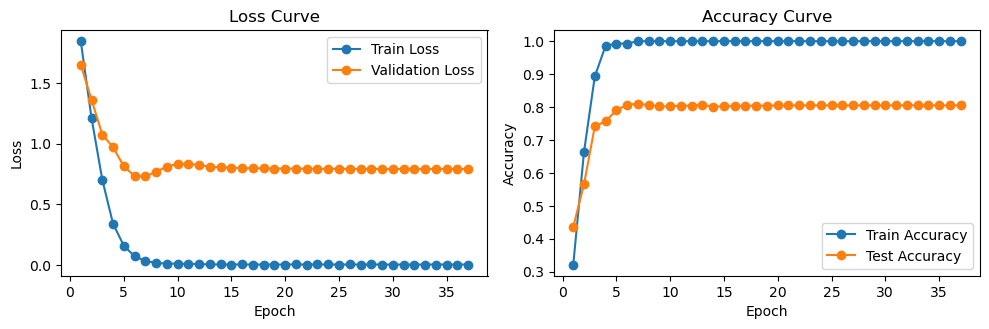

In [53]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss_training) + 1)

plt.figure(figsize=(10, 6))

# Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, loss_training, 'o-', label='Train Loss')
plt.plot(epochs, loss_val, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, acc_train, 'o-', label='Train Accuracy')
plt.plot(epochs, acc_test, 'o-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()
